# Lab 3 Stat 663

In this lab, you'll use resnet50 to classify art from different food.
Prior to classifying we will use the hugging map function to resize the image to (224,224,3) from: https://huggingface.co/datasets/huggan/wikiart

You'll finetune the ResNet model to clasify what food type is show in the image.

# Runtime

Be sure to use High-RAM and at least a T4 GPU runtime



### Revanth Chowdary Ganga - rg361

In [1]:
%%capture
# Loading the required libraries
!pip install datasets -q

import PIL
from datasets import load_dataset
import tensorflow as tf
import matplotlib.pyplot as plt

2024-03-19 23:03:23.412503: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 23:03:26.147307: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 23:03:31.968568: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 23:03:38.564897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# using falg variable to select the dataset to be used
data_flag = False

if data_flag:
    # Load the full Dataset
    dataset = load_dataset("food101")
else:
    # take a smaller slice for this lab (faster train)
    dataset = dict(
        zip(
            ["train", "validation"],
            load_dataset("food101", split=["train[20%:30%]", "validation[20%:30%]"]),
        )
    )

In [3]:
# @title Data Preprocessing


@tf.function
def process_image(ele):
    image = ele["image"]
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (224, 224))
    return image, ele["label"]


# We will need to convert to tensorflow if we want to use Keras Library
train_tf = dataset["train"].shuffle().to_tf_dataset()

# Map calls the process_iamge function on the fly. It is a good idea so you don't
# Need to process the entire dataset, instead you can grab it as needed
train_tf = train_tf.map(process_image, num_parallel_calls=8)

# to ignore the images which cause problems
train_tf = train_tf.ignore_errors(log_warning=True)

# Let's hook into our processing pipeline to take a look at what our inputs look like
visualize_tf = train_tf

# We can cache our processing so after our first pass, we don't need to process again
train_tf = train_tf.cache()

# SGD requires random batches, let's shuffle the order so we are not grabbing the same
# mini batch combination every time.
train_tf = train_tf.shuffle(1000)

# 128 seems like a reasonable batch size to start with. We drop the remainder
# so that we always have 128 size. This chops off the last examples, but it should
# not be a big deal
train_tf = train_tf.batch(128, drop_remainder=True)

# Prefetch so that while the GPU is training a step, the CPU is processing the data ahead of time
train_tf = train_tf.prefetch(2)

In [4]:
# @title Test Data Preprocessing TODO YOU

# Let's do the same thing to our test dataset, but without all the comments
# here is how clean your data processing pipeline can look!
test_tf = dataset["validation"].to_tf_dataset()
test_tf = test_tf.map(process_image, num_parallel_calls=8)
test_tf = test_tf.ignore_errors(log_warning=True)
visualize_test_tf = test_tf
test_tf = test_tf.cache()
test_tf = test_tf.batch(128, drop_remainder=True)
test_tf = test_tf.prefetch(2)

# Your test data does not need to be shuffled

Text(0.5, 1.0, 'Tensorflow API: pancakes')

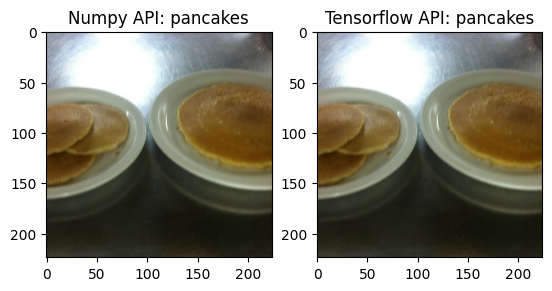

In [5]:
# @title Visualization

img, label = next(iter(visualize_tf))

# Normalize the image from 0-1 to work with matplotlib
tf_img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) + tf.reduce_min(img))

# Go from tensorflow API land => numpy API land to process data
# in the API of your preference.
img = img.numpy()
img = (img - img.min()) / (img.max() + img.min())

# Subplots allow us to plot multiple images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title(f"Numpy API: {dataset['train'].features['label'].names[label]}")
axes[1].imshow(tf_img)
axes[1].set_title(f"Tensorflow API: {dataset['train'].features['label'].names[label]}")

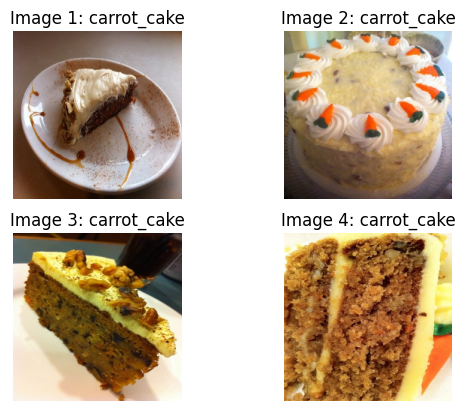

In [6]:
# @title Testing Set Visualization TODO YOU

# Using matplotlib subplot, plot a 2x2 grid of images of the first 4 images
# Fetch the first batch of images from the test dataset
test_images = []
test_labels = []
for i, (img, label) in enumerate(iter(visualize_test_tf)):
    test_images.append(img)
    test_labels.append(dataset["validation"].features["label"].names[label])
    if i == 3:
        break

fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i].numpy())
    ax.set_title(f"Image {i+1}: {test_labels[i]}")
    ax.axis("off")

plt.show()

In [7]:
# @title Dimension Check

img, label = next(iter(train_tf))
print(img.shape)
print(label.shape)

# >> (128, 224, 224, 3)
# >> (128,)
# Note that our input size is (batch_size, height, width, color)
# Note that our label is (batch_size, )

2024-03-19 23:06:07.771496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 673 of 1000
2024-03-19 23:06:10.789183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


(128, 224, 224, 3)
(128,)


2024-03-19 23:06:11.937441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
# @title Testing Set Dimension Check TODO YOU

# Check that the dimensions of your test dataset are the same as your training
# TODO YOUR CODE HERE
img, label = next(iter(test_tf))
print(f"Shape of Test Image:{img.shape}")
print(f"Shape of Test Label:{label.shape}")

Shape of Test Image:(128, 224, 224, 3)
Shape of Test Label:(128,)


2024-03-19 23:06:20.241737: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
# @title Modeling

# Load the pretrained ResNet50 model
# We load the imagenet pretrained weights
# We don't "include_top" because imagenet is 1000 classes, we care about
# our food 101 problem which contains 101 classes
# We use global average pooling as the last layer as in the resnet50 paper
# to get our 'feature vector'
resnet_model = tf.keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling="avg"
)

# Let's visualize the model dimensions through each layer
# Our final output dimension is (None, 2048)
# The reason it is None is because our batch size can be of any size, we just so
# happen to choose 128

resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
# @title Modify ResNet50

# Let's use composability to model the food 101 problem

# Let's grab the input and outputs of our model
resnet_input = resnet_model.input
resnet_output = resnet_model.output

# We want to pass our outputs into the following:
# We choose 101 because we have 101 classes
# We use a softmax activation because each image can only be one class
# pizza or hotdog, not pizza and hotdog right? Thus softmax is the right way to
# model our problem.
# We add a couple more layers
new_outputs = tf.keras.layers.Dense(101, activation="softmax")(resnet_output)

# Let's rewire a new model which takes in resnet_inputs and uses our new_outputs
model = tf.keras.Model(resnet_input, new_outputs)

# Lastly, remember when we apply SGD we can selectively decide what we want to train.
# If there are weights we don't want to train we can simply mark them as trainable=False
# This is known as "freezing weights", we only want to train our last layer and preserve all
# the pretrianed goodness from our imagenet weights
# You can optionally experiment with this by setting all or some of the layers to trainable
# resnet_model.trainable = False
# resnet_model.layers[-1].trainable = True
# resnet_model.layers[-2].trainable = True
# etc etc


# Let's also visualize the model, note that the last layer is now our Dense(101) layer
# You'll also see that the number of "trainable" params is only the Dense layer
model.summary()
# >> Trainable params: 206949 (808.39 KB)
# >> Non-trainable params: 23587712 (89.98 MB)
# Phew 206949 << 23587712, this will make training a lot faster and stable with small
# datasets.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,794,661 (90.77 MB)

 Trainable params: 23,741,541 (90.57 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
# @title Compile the model

# In this step, we select the optimizer and loss
# in class we learned about SGD, here the optimizer we use is ADAM which is
# just "fancier" SGD. We'll go over this in class at some point

# We select the sparse_categorical_crossentropy since our labels are 0, 1, 2 ... 101
# for each food type.

# Compile the model
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [12]:
# You don't need to wait for this to finish. You can start on the next section
# Assume this will continue to converge. As long as accuracy go up, we are in the clear
# For some reason the pipeline also crashes due to a pipelining error.
model.fit(train_tf, epochs=2)

Epoch 1/2
     19/Unknown 279s 13s/step - accuracy: 0.4235 - loss: 2.3859

2024-03-19 23:11:43.650964: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Shape of tensor args_0 [512,510] is not compatible with expected shape [?,?,3].
	 [[{{node EnsureShape}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 808s 13s/step - accuracy: 0.5310 - loss: 1.7625
Epoch 2/2


2024-03-19 23:20:32.197488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


59/59 ━━━━━━━━━━━━━━━━━━━━ 774s 13s/step - accuracy: 0.7967 - loss: 0.6482


2024-03-19 23:33:26.425715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [13]:
# @title Train with test data TODO YOU

# You should see a val_accuracy in addition to accuracy
# You'll also notice that validation in general is a little lower than your true
# accuracy. This is because your model may "overfit" to your training set
# This is why validation sets are important
model.fit(train_tf, epochs=5, validation_data=test_tf)

Epoch 1/5
     59/Unknown 773s 13s/step - accuracy: 0.8901 - loss: 0.3515

2024-03-19 23:46:19.576912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 824s 14s/step - accuracy: 0.8900 - loss: 0.3509 - val_accuracy: 0.0781 - val_loss: 3.2938
Epoch 2/5


2024-03-19 23:47:10.077325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9307 - loss: 0.2102 

2024-03-20 00:00:04.295557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 820s 14s/step - accuracy: 0.9304 - loss: 0.2101 - val_accuracy: 0.0977 - val_loss: 3.1556
Epoch 3/5


2024-03-20 00:00:50.264263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9409 - loss: 0.1788 

2024-03-20 00:13:41.542592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 818s 14s/step - accuracy: 0.9407 - loss: 0.1789 - val_accuracy: 0.0785 - val_loss: 4.0873
Epoch 4/5


2024-03-20 00:14:27.999927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9566 - loss: 0.1430 

2024-03-20 00:27:21.003724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 820s 14s/step - accuracy: 0.9564 - loss: 0.1427 - val_accuracy: 0.0000e+00 - val_loss: 4.5505
Epoch 5/5


2024-03-20 00:28:07.860316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.9552 - loss: 0.1389 

2024-03-20 00:41:00.386083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


59/59 ━━━━━━━━━━━━━━━━━━━━ 819s 14s/step - accuracy: 0.9549 - loss: 0.1389 - val_accuracy: 0.0000e+00 - val_loss: 5.6721


2024-03-20 00:41:47.111996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Custom Layer

So far, we have been relying on the high level keras layers such as `Dense()`
to do what we need. Instead of using the premade Dense layer, we will create a custom `MyDense()` layer from scratch which mimics the functionality as we did in the above work.

For details see https://www.tensorflow.org/tutorials/customization/custom_layers#implementing_custom_layers

Try running the model code again, but use MyDenseLayer() instead

In [14]:
class MyDenseLayer(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(MyDenseLayer, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.num_outputs),
            initializer="random_normal",
            trainable=True,
        )
        self.bias = self.add_weight(
            name="bias", shape=(self.num_outputs,), initializer="zeros", trainable=True
        )

    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel) + self.bias
        return tf.nn.softmax(output)


layer = MyDenseLayer(10)

In [15]:
# The code does the same as our previous, but just more compact
# Wow we are really just running a couple of lines.
model = tf.keras.Sequential(
    [
        tf.keras.applications.ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        MyDenseLayer(101),
    ]
)

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(train_tf, epochs=1)

59/59 ━━━━━━━━━━━━━━━━━━━━ 793s 13s/step - accuracy: 0.5180 - loss: 1.9344


2024-03-20 01:06:34.431255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


# Gradient Exploration

In [16]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))


x = tf.constant(100.0)

# When we use the gradient tape, we are calculating the backprop values for all
# functions we use.

with tf.GradientTape() as g:
    g.watch(x)

    # Unfortunately, the automatic backprop gradient calculated for our function
    # results in nan for large values...
    y = log1pexp(x)

dy_dx = g.gradient(y, x)

print(dy_dx)  # :sad_face:

tf.Tensor(nan, shape=(), dtype=float32)


In [17]:
# @title Replacing the default gradient with a custom gradient


# This decorator allows us to define our own custom grad function which is
# returned when our computational graph is constructed
@tf.custom_gradient
def fix_log1pexp(x):
    e = tf.exp(x)  # we save the value e because we can reuse it

    def grad(dy):
        """
        dy is our upstream gradient, remember we need to multiply our dy with our local
        gradient which is calculated to be (1 - 1/(1+e))
        """
        return dy * (1 - 1 / (1 + e))

    return tf.math.log(1 + e), grad


with tf.GradientTape() as g:
    g.watch(x)

    # Unfortunately, the automatic backprop gradient calculated for our function
    # results in nan for large values...
    y = fix_log1pexp(x)

dy_dx = g.gradient(y, x)

print(dy_dx)  # :happy_face:

tf.Tensor(1.0, shape=(), dtype=float32)


In [18]:
@tf.custom_gradient
def stable_division(a, b, epsilon=1e-12):
    def grad(dy):
        abs_b = tf.abs(b)
        sign_b = tf.sign(b)
        da = dy / (abs_b + epsilon) * sign_b
        db = -dy * a / ((abs_b + epsilon) ** 2) * sign_b
        return da, db

    return a / (tf.abs(b) + epsilon) * tf.sign(b), grad


# Example usage
x = tf.constant([1.0, 2.0, 3.0])
y = tf.constant([0.0, -1e-12, 1e-12])
with tf.GradientTape() as tape:
    tape.watch([x, y])
    z = stable_division(x, y)

dz_dx, dz_dy = tape.gradient(z, [x, y])
print("Output:", z.numpy())
print("Gradient w.r.t x:", dz_dx.numpy())
print("Gradient w.r.t y:", dz_dy.numpy())

Output: [ 0.0e+00 -1.0e+12  1.5e+12]
Gradient w.r.t x: [ 0.e+00 -5.e+11  5.e+11]
Gradient w.r.t y: [-0.0e+00  5.0e+23 -7.5e+23]


In [19]:
# @title Once you complete stable division, you should no longer get inf
x = tf.constant([1.0, 2.0, 3.0])
y = tf.constant([0.0, -1e-12, 1e-12])
with tf.GradientTape() as tape:
    tape.watch([x, y])
    z = stable_division(x, y)

dz_dx, dz_dy = tape.gradient(z, [x, y])
print("Output:", z.numpy())
print("Gradient w.r.t x:", dz_dx.numpy())
print("Gradient w.r.t y:", dz_dy.numpy())

Output: [ 0.0e+00 -1.0e+12  1.5e+12]
Gradient w.r.t x: [ 0.e+00 -5.e+11  5.e+11]
Gradient w.r.t y: [-0.0e+00  5.0e+23 -7.5e+23]
